---
# Ensure that this title is the same as the one in `myst.yml`
title: Developer Notes - Core Team Template
abstract: |
  This tutorial describes how you visualize and extract kinetic parameters from a fluorescent plate reader experiment to enable consistent data reporting across the nucleus ecosystem. Within a few minutes, datasets can be rendered into a form suitable for sharing.

  *Click the ***"Launch Jupyter" button*** to modify this code and use on your own data*
---

A shared understanding of how to interpret data from CFE systems would speed the development of measurements and standards towards improved reproducibility and address challenges in interpreting and comparing existing and future data, including data from failed experiments ([NIST, 2024](https://doi.org/10.6028/NIST.SP.1500-26)). Time-course measurements of the product expressed in the cytosol are favored over endpoint measurements, despite the time, labor, and costs involved, to obtain a more complete and informative view of a cytosol. This package helps to standardize the reporting of measurements as a reduced quantity, such as a mean value, with uncertainty and include a baseline from negative control measurements. The collection of such data enable reaction optimization and the development of predictive modeling tools.

## Experimental setup

In order to make the most of this toolkit it is necessary to ensure that your has been designed following best practices to include replicates and controls. When designing an experiment we recommend following our platemap guide. Additionally, the following code makes some assumptions regarding the format of the incoming data. If you are using a Cytation instrument see our Getting started guide. Otherwise, it might be necessary to write some glue code to transform your raw data into a format compatible with this library. 

TODO: need to be more specific about about acceptable formatting requirements -> towards a platemap guide; what is a a good way to describe this?

## Python imports

First we import standard python packages alongside our custom library called [cdk](https://github.com/bnext-bio/bnext/blob/cdk-layout/cdk/src/cdk/analysis/cytosol/platereader.py). Currently, this package contains several functions:

- `load_platereader_data()`
- `plot_plate()`
- `plot_curves_by_name()`
- `plot_curves()`
- `find_steady_state()`
- `plot_steady_state()`
- `kinetic_analysis()`
- `plot_kinetic_analysis()`

In what follows, we will demonstrate the use of these functions on some sample data. You can test out these functions for yourself by launching a Jupyter Notebook located at the top of this article and adding your own platemap and data to the appropriate directory as described below.

In [17]:
%load_ext autoreload
%autoreload 2

from src.cdk.analysis.cytosol import platereader as pr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas
import src.cdk.logging

log = src.cdk.logging.setup_logging()
pr.plot_setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[11/26/24 13:20:05] INFO     Logging initialized                  __init__.py:26


## Load data

Load your fluorescent timeseries data and experimental platemap. They should be formatted as .txt and .csv files, respectively. The `data` output will be used in subsequent plotting functions

In [18]:
data, platemap = pr.load_platereader_data("tests/test_data/cytation_dna_sweep.txt", "tests/test_data/platemap.csv")
data.head()

,Well,Row,Column,Time,Seconds,Temperature (C),Read,Data,Experiment,Name,DNA Template,[DNA Template] (ng/uL)
0,B1,B,1,0 days 00:00:00,0.00,37.00,"490,520",289.00,Concentration,pT7-deGFP 100,pT7-deGFP (AR-11),100.00
1,B1,B,1,0 days 00:05:00,300.00,37.00,"490,520",312.00,Concentration,pT7-deGFP 100,pT7-deGFP (AR-11),100.00
2,B1,B,1,0 days 00:10:00,600.00,37.00,"490,520",449.00,Concentration,pT7-deGFP 100,pT7-deGFP (AR-11),100.00
3,B1,B,1,0 days 00:15:00,900.00,37.00,"490,520",982.00,Concentration,pT7-deGFP 100,pT7-deGFP (AR-11),100.00
4,B1,B,1,0 days 00:20:00,1200.00,37.00,"490,520",1880.00,Concentration,pT7-deGFP 100,pT7-deGFP (AR-11),100.00


Verify the contents of the platemap by running `platemap`. Notice that this platemap contains two separate Experiments `Concentration` and `Artifact`. The Experiment parameter will be used in some of the downstream plotting functions below. See TODO: platemap guide for more information on setting up a platemap.

In [19]:
platemap

,Well,Experiment,Name,DNA Template,[DNA Template] (ng/uL)
0,B1,Concentration,pT7-deGFP 100,pT7-deGFP (AR-11),100.00
1,B2,Concentration,pT7-deGFP 50,pT7-deGFP (AR-11),50.00
2,B3,Concentration,pT7-deGFP 20,pT7-deGFP (AR-11),20.00
3,B4,Concentration,pT7-deGFP 10,pT7-deGFP (AR-11),10.00
4,B5,Concentration,pT7-deGFP 5,pT7-deGFP (AR-11),5.00
5,B6,Concentration,pT7-deGFP 2,pT7-deGFP (AR-11),2.00
6,B7,Concentration,pT7-deGFP 1,pT7-deGFP (AR-11),1.00
7,B8,Concentration,pT7-deGFP 0,pT7-deGFP (AR-11),0.00
8,C1,Artifact,pT7-lacO-plamGFP 29.3,pT7-lacO-plamGFP (20240622),29.30
9,C2,Artifact,pT7-lacO-plamGFP 35.8,pT7-lacO-plamGFP (20240626),35.80


## Inspect data

Use `plot_plate()` to look at plots of plate reader data, laid out the same as the plate. This provides you with a simple way to get a quick over view of your data across the entire well plate.

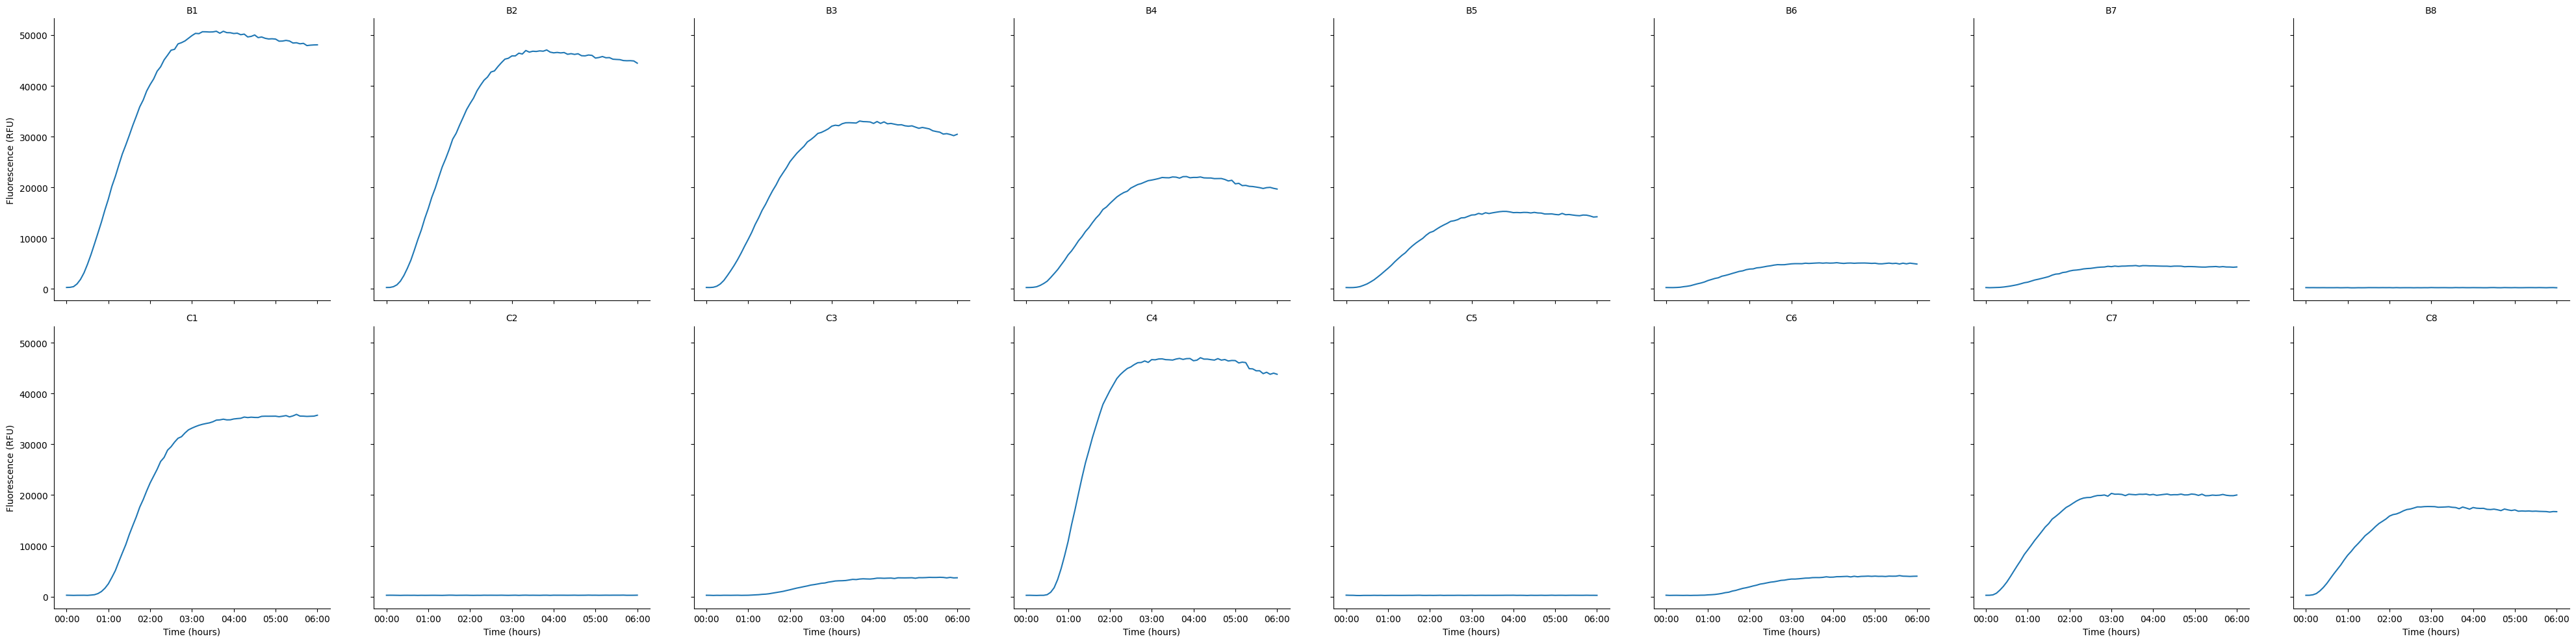

In [20]:
pr.plot_plate(data);

### Gather timeseries data by experiment

Use `plot_curves_by_name()` to plot all curves, with one plot per Name - in this case Name -> Experiment. This provides you with a simple way to compare data within a set of predetermined experimental parameters. See the [Experimental setup](#Experimental-setup) section for guidelines.

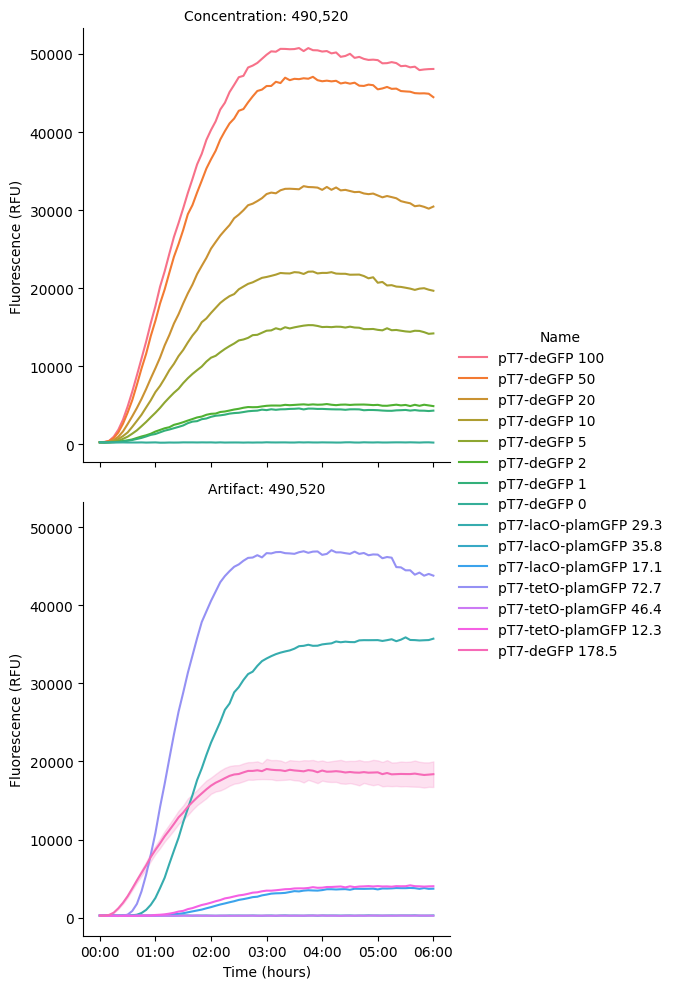

In [21]:
pr.plot_curves_by_name(data=data);

Use `plot_curves()` to plot curves with control over how the data is separated.

NOTE: is there a more interesting use case that we can show that highlights where this is different between the function above

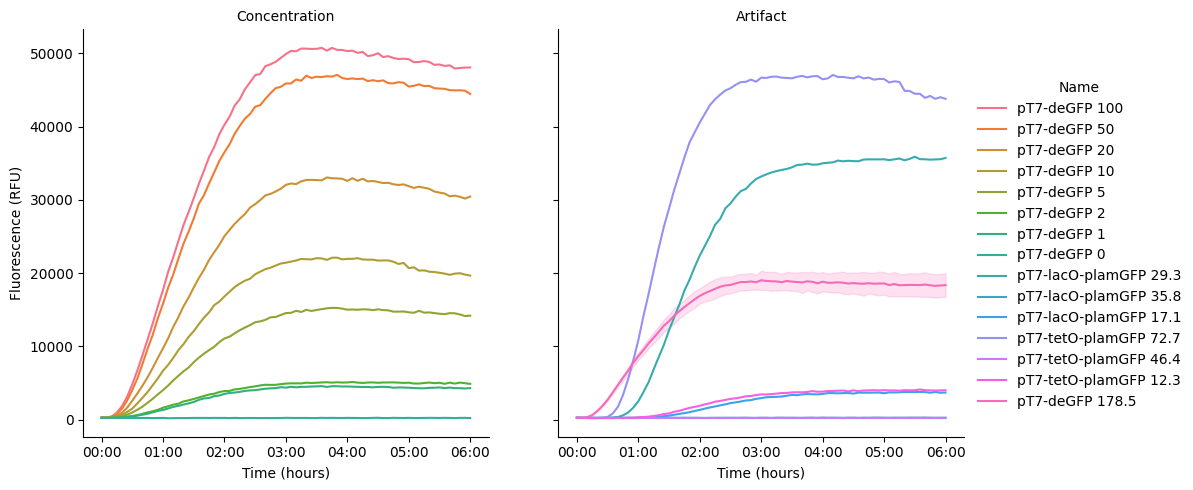

In [22]:
pr.plot_curves(data, hue="Name", col="Experiment");

### Calculate and plot steady state 

Use `find_steady_state()` to obtain a table the time and intensity of steady state fluorescence.

Plot steady state fluorescence is based on our steady state definition. There are three potential ways to calculate steady state:
1. Steady state determined by the point of minimum change (i.e., where velocity is closest to zero). This is what we do by default.
2. Steady state determined by the maximum fluorescence value. This is the simplest to explain and understand.
3. Steady state as calculated by the intercept of the $V_{max}$ line with the maximum data value. This tends to match our intuition about where the steady state is the least, but has pleasing symmetry with the way we calculate the lag time (intercept of $V_{max}$ with zero).

NOTE: what is our definition of steady state?
NOTE: this would be more useful if experiment_name was also in the dataframe

In [23]:
pr.find_steady_state(data)

,,Time_steadystate,Data_steadystate
Well,Read,,
B1,"490,520",0 days 03:30:00,50621.00
B2,"490,520",0 days 03:45:00,46821.00
B3,"490,520",0 days 04:25:00,32592.00
B4,"490,520",0 days 05:55:00,19808.00
B5,"490,520",0 days 04:30:00,15073.00
B6,"490,520",0 days 04:10:00,5075.00
B7,"490,520",0 days 03:20:00,4498.00
B8,"490,520",0 days 03:20:00,253.00
C1,"490,520",0 days 05:10:00,35535.00


Use `plot_steadystate()` to plot all steady state intensities, with one plot per Experiment.

NOTE: should it be plot_steadystate_by_name() to be consistent with the above funcitons

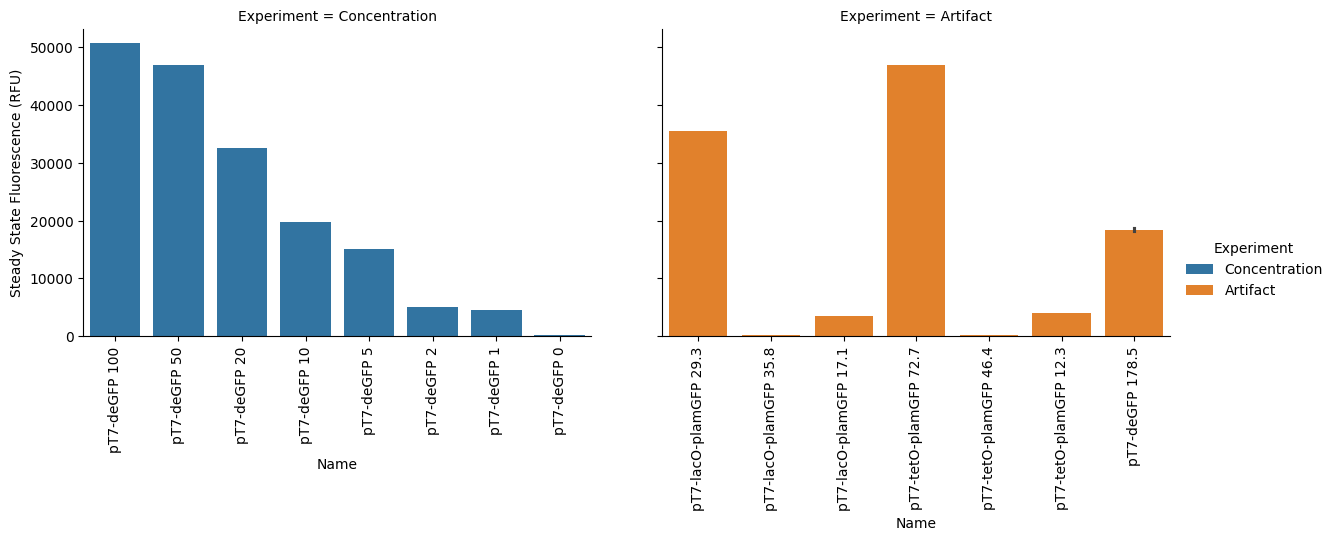

In [24]:
pr.plot_steadystate(data);

:::{admonition} Note
:class: note

The `hue` argument can be used to emphasize experimental parameters described in `platemap`. For example, `[DNA Template]`.
:::

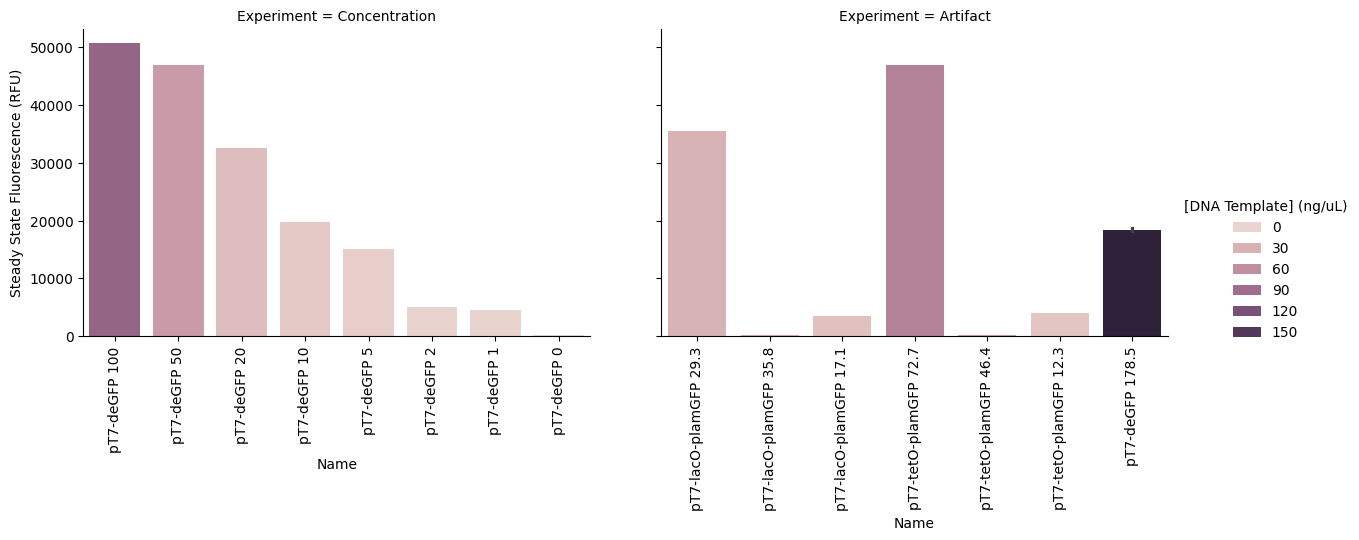

In [25]:
pr.plot_steadystate(data, hue="[DNA Template] (ng/uL)");

### Kinetic analysis

Use `kinetic_analysis()` to obtain a table with calculate kinetic parameters. The following parameters are calculated:

- $t_{max}$ Time to reach the maximum yield of product expressed, as the time from the start of the measurement to the time to reach the maximum yield;
- $ v_{max}$ Maximum rate of product expression, as the maximum linear rate of production;
- $t_{lag}$, as the time from the start of the measurement to the time to reach the maximum rate of expression;

See ([NIST, 2024](https://doi.org/10.6028/NIST.SP.1500-26)) for a more thorough explanation. 

In [26]:
kinetics = pr.kinetic_analysis(data);

[11/26/24 13:20:09] WARNING  Failed to solve: Optimal         platereader.py:501
                             parameters not found: Number of                    
                             calls to function has reached                      
                             maxfev = 800.                                      
                    WARNING  Failed to solve: Optimal         platereader.py:501
                             parameters not found: Number of                    
                             calls to function has reached                      
                             maxfev = 800.                                      


:::{admonition} Warning
:class: warning

If kinetics can't be solved for a given well, a warning will be printed and that well will have "Not a Number" (NaN) or "Not a Time" (NaT) for the relevant parameters.
:::

                    INFO     Kinetics information not         platereader.py:618
                             available for C2.                                  
                    INFO     Kinetics information not         platereader.py:618
                             available for C5.                                  


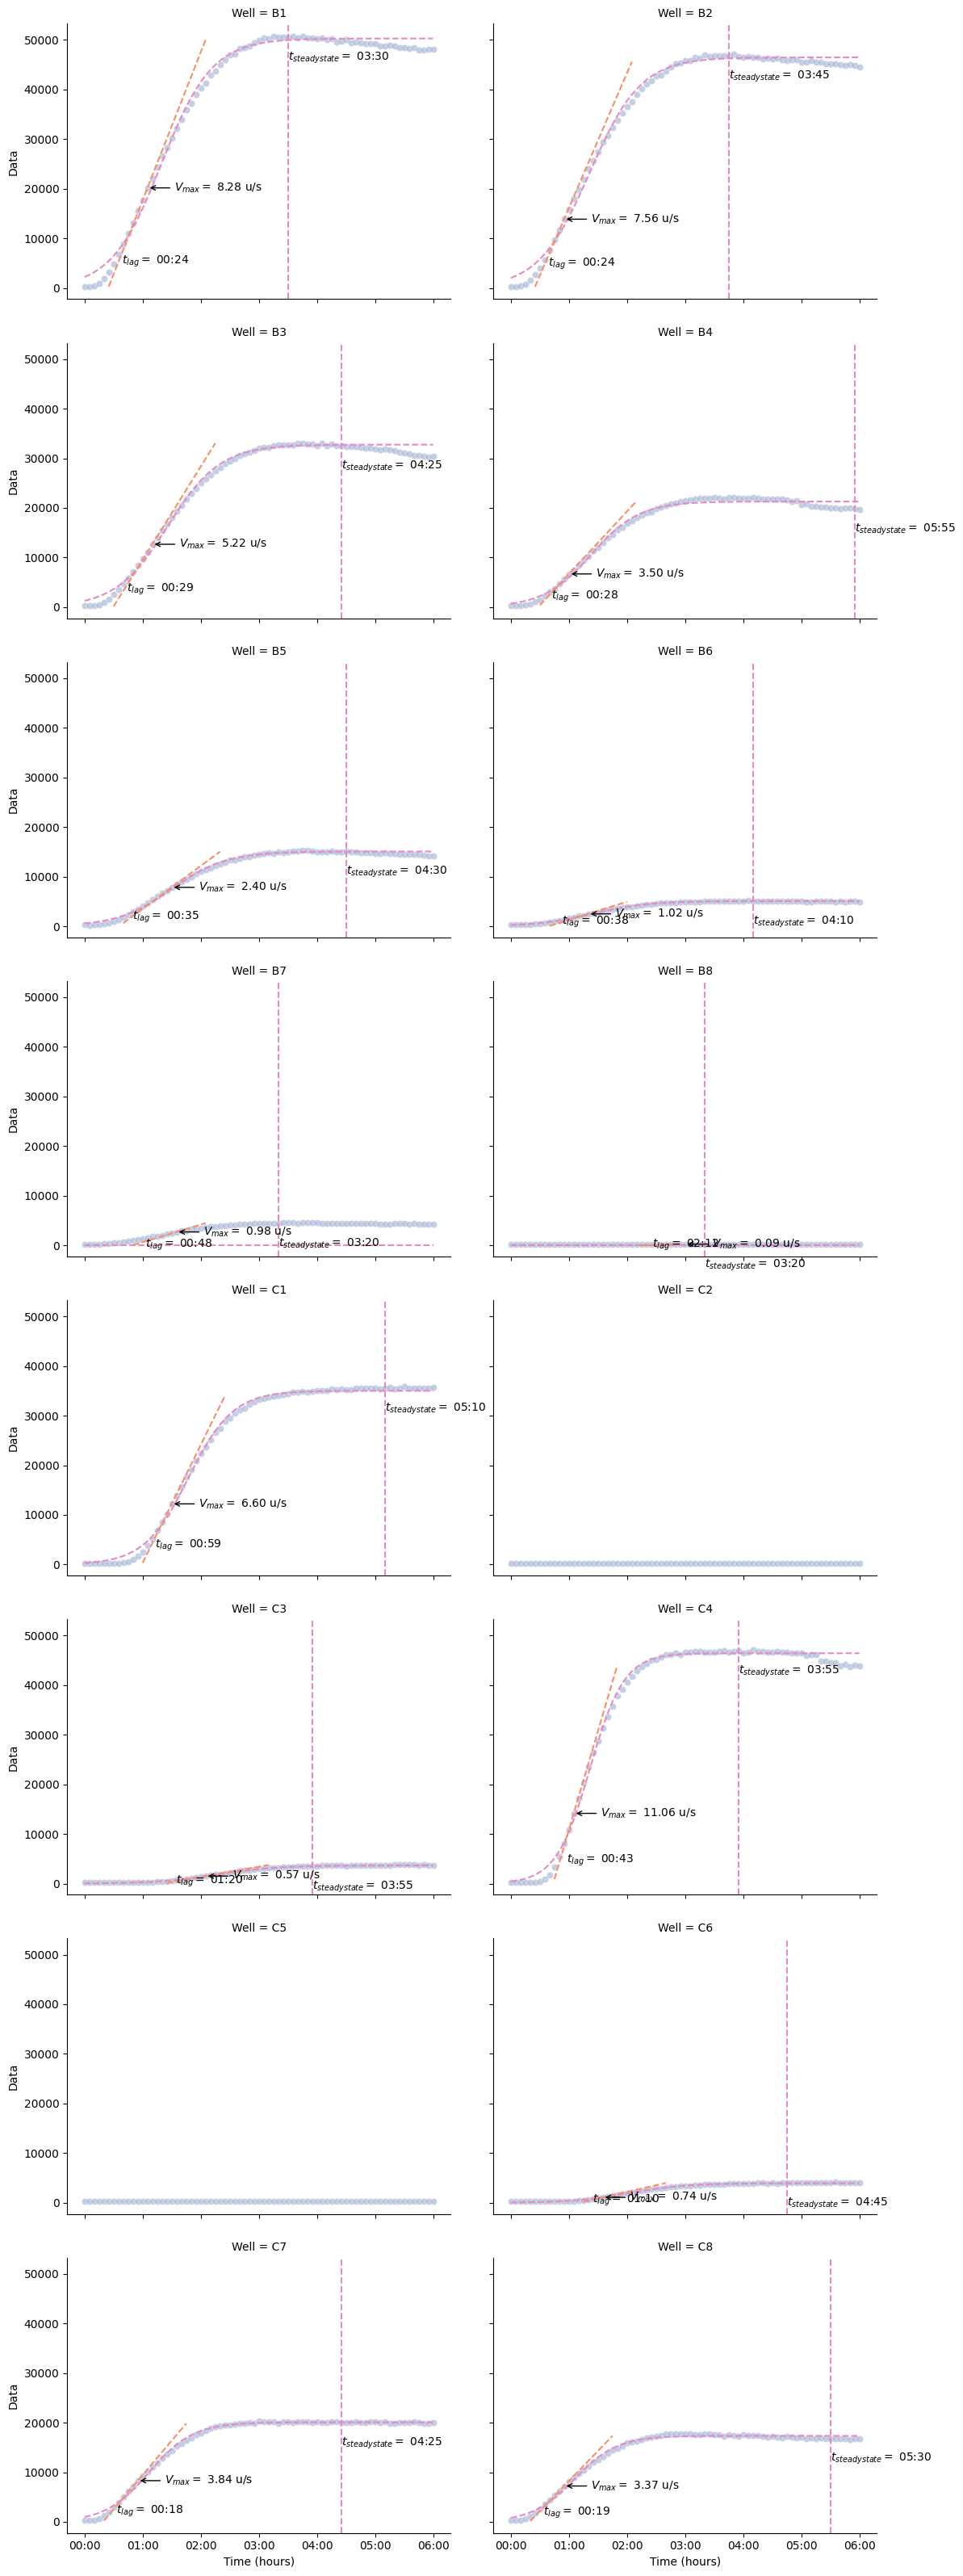

In [27]:
pr.plot_kinetics(data, kinetics);

## Experimental: holoviz

In [28]:
data.hvplot(
    by=['[DNA Template] (ng/uL)'],
    groupby=['Experiment'],
    kind='line',
    logy=True,
    x='Time',
    y=['Data'],
    legend='bottom_right',
    widget_location='top',
    height=500
)

data.hvplot.explorer(x="Time", y="Data", by=["Name"], groupby=["Experiment"])

ModuleNotFoundError: No module named 'jupyter_bokeh'

hvDataFrameExplorer(advanced=Advanced(explorer=..., name='Advanced00555', opts=None), axes=Axes(explorer=..., height=None, legend='bottom_right', logx=False, logy=False, name='Axes00549', responsive=True, shared_axes=True, width=None, xlim=None, ylim=None), by=['Name'], code="df.hvplot(\n    by=['Name'],\n    groupby=['Experiment'],\n    kind='scatter',\n    x='Time',\n    y=['Data'],\n    legend='bottom_right',\n    widget_location='bottom',\n)", colormapping=Colormapping(clim=None, cmap='kbc_r', cnorm='linear', color=None, colorbar=None, explorer=..., name='Colormapping00550', rescale_discrete_levels=True, symmetric=False), geographic=Geographic(crs=None, crs_kwargs={}, explorer=..., feature_scale='110m', features=None, geo=False, global_extent=None, name='Geographic00552', project=False, projection=None, projection_kwargs={}, tiles=None), groupby=['Experiment'], kind='scatter', labels=Labels(clabel='', explorer=..., fontscale=1, name='Labels00551', rot=0, title='', xlabel='', ylabel